In [1]:
import folium
import geopandas as gpd
import pyepsg
import pandas as pd
from folium.element import IFrame
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
# import rt
import matplotlib.pylab as plt

%matplotlib inline

## BE CAREFUL OF UNITS

In [2]:
Average_Power_Use_per_capita = 40.0*1e-6 #(MWatts per person)
Lifetime_Energy_Use_Per_Capita = 4000.0 # kWh/person/life of transmission line
cost_grid_connected = 0.036 # dollars/kWh
lcoe_coeff = -0.0025 #($/kWh)

In [3]:
villages = gpd.GeoDataFrame.from_file("./VillageMetrics_output/")
cities_towns = gpd.GeoDataFrame.from_file("./citiestownpopulation2013.geojson")
census_data = pd.read_csv("./HouseholdPopulationbaseddatasetMIMUTownshipsabbreviated.csv")

In [4]:
table = """
<!DOCTYPE html>
<html>
<head>
<style>
table {{
    width:100%;
}}
table, th, td {{
    border: 1px solid black;
    border-collapse: collapse;
}}
th, td {{
    padding: 5px;
    text-align: left;
}}
table#t01 tr:nth-child(odd) {{
    background-color: #eee;
}}
table#t01 tr:nth-child(even) {{
   background-color:#fff;
}}
</style>
</head>
<body>

<table id="t01">
  <tr>
    <td>Name</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Population</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Distance from Grid</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Total off Grid Cost</td>
    <td>{}</td>
  </tr>
    <tr>
    <td>Total on Grid Cost</td>
    <td>{}</td>
  </tr>
</table>
</body>
</html>
""".format

In [5]:
villages.columns

Index([  u'District', u'District_c', u'GHI_wpm2_1',   u'Gr_ml_cm',
          u'HHPhase',  u'Ho_size_r',  u'Ho_size_u',   u'Latitude',
        u'Longitude',    u'MVPhase', u'MV_distanc',   u'Mg_fl_cl',
             u'Name', u'NightLig_1', u'NightLight',   u'OBJECTID',
         u'Pop_2001',   u'Pop_2011',   u'Pop_2013',    u'Pop_g_r',
          u'Pop_g_u', u'Population',     u'Source',      u'State',
       u'State_code',     u'System', u'Target_hou',   u'Township',
       u'Township_c',    u'Village', u'Village_co', u'Village_fa',
       u'Village_hh', u'Village_po', u'Villagetra',    u'Vt_code',
            u'Vt_hh',     u'Vt_pop',  u'd_MVlines',     u'd_road',
         u'geometry'],
      dtype='object')

In [6]:
villages.head()

,District,District_c,GHI_wpm2_1,Gr_ml_cm,HHPhase,Ho_size_r,Ho_size_u,Latitude,Longitude,MVPhase,...,Village_fa,Village_hh,Village_po,Villagetra,Vt_code,Vt_hh,Vt_pop,d_MVlines,d_road,geometry
0,NULL,0,214.926,20,1,6.20,5.85,20.137222,92.885556,1,...,0,0,0,NULL,0,0,0,156373.495616,153.318168,POINT (92.88555600000007 20.13722200000007)
1,NULL,0,214.992,20,1,6.20,5.85,20.818889,92.367778,1,...,0,0,0,NULL,0,0,0,215488.135547,52.672790,POINT (92.36777800000004 20.81888900000007)
2,None,0,217.816,19,1,5.71,5.27,20.881944,95.863056,1,...,0,0,0,None,0,0,0,1773.712258,1625.482094,POINT (95.86305600000009 20.88194400000003)
3,None,0,199.920,21,1,7.96,6.01,25.387500,97.390278,1,...,0,0,0,None,0,0,0,1476.386156,1157.620835,POINT (97.39027800000008 25.38750000000005)
4,None,0,205.727,20,1,6.98,5.59,23.990000,97.901667,1,...,0,0,0,None,0,0,0,1032.353947,476.490891,POINT (97.90166700000003 23.99000000000007)


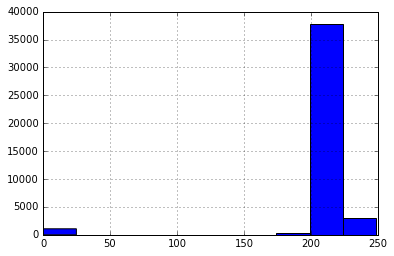

In [7]:
villages.GHI_wpm2_1.hist()

In [8]:
villages[villages.NightLig_1==1]["Population"].sum()/float(villages["Population"].sum())

0.23107259662485233

In [9]:
villages = villages.dropna()
villages = villages[villages.Population>0]

In [10]:
villages["RequiredPower"] = villages["Population"]*Average_Power_Use_per_capita

In [11]:
rated_power_range_cost = {"<30":28.177,"30-100":43.687,"100-150":78.036,"150-300":108.205,">300":151.956}

In [12]:
def transmission_cost(x,costs = rated_power_range_cost):
    retval = 0
    if x<30:
        retval=costs["<30"]
    if (x>=30) & (x<100):
        retval=costs["30-100"]
    if (x>=100) & (x<150):
        retval=costs["100-150"]
    if (x>=150) & (x<300):
        retval=costs["150-300"]
    if x>=300:
        retval=costs[">300"]
    return retval

In [13]:
villages["TransCostRRTP"] = villages["RequiredPower"].apply(lambda x: transmission_cost(x))

In [14]:
villages["TransmissionCost"] = villages["d_MVlines"]*villages["TransCostRRTP"]/(villages["Population"]*Lifetime_Energy_Use_Per_Capita)

In [15]:
villages["onGridCosts"]=villages["TransmissionCost"]+cost_grid_connected

In [16]:
# villages = villages[villages["onGridCosts"]]

In [17]:
villages["offGridCostsStandAlone"] = lcoe_coeff*villages["GHI_wpm2_1"]+1

In [18]:
(villages["offGridCostsStandAlone"]>villages["onGridCosts"]).sum()

22083

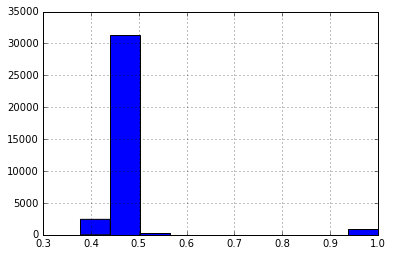

In [19]:
villages["offGridCostsStandAlone"].hist()

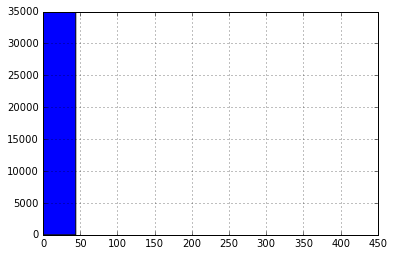

In [20]:
villages["onGridCosts"].hist()

In [21]:
villages["onGridCosts"].max()

439.25511859670399

In [22]:
villages_tmp = villages.sample(3000)

In [23]:
myanmar_map = folium.Map([20, 95],
                  zoom_start=6,
                  tiles='cartodbpositron')
width, height = 310,170
popups, locations = [], []
for idx, row in villages_tmp.iterrows():
    locations.append([row['Latitude'], row['Longitude']])
    name = row['Name'].encode('ascii', 'xmlcharrefreplace')
    opr = row['MV_distanc']
    population_current = row["Population"]
    isElectrified = row["NightLig_1"]
    offGridCost = row["offGridCostsStandAlone"]
    onGridCost = row["onGridCosts"]
    iframe = IFrame(table(name, population_current, opr,offGridCost,onGridCost), width=width, height=height)
    popups.append(iframe)
    
h = folium.FeatureGroup(name='Hydroelectric')
child1 = MarkerCluster(locations=locations, popups=popups)
# h.add_child(child1)
child1.name="All Villages"
myanmar_map.add_child(child1)
# myanmar_map.add_child(HeatMap(zip(villages["Latitude"],
#                                      villages["Longitude"],
#                                      villages["Missing Electricity"]),radius=5), name="Missing Electricity HeatMap")
# myanmar_map.add_child(HeatMap(zip(villages["Latitude"],
#                                      villages["Longitude"],
#                                      villages["Missing Electricity"]),radius=5), name="Missing Electricity HeatMap")

myanmar_map.add_child(folium.LayerControl())
myanmar_map.save("withOnOffCosts.html")

In [24]:
map = folium.Map([20, 95],
                  zoom_start=6,
                  tiles='cartodbpositron')
map.choropleth(geo_path=circles.to_json(), data=villages_tmp,
             columns=['Name', 'Missing E lectricity'],
             key_on='Name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2)
map.save('us_states.html')

NameError: name 'circles' is not defined